In [1]:
import pandas as pd
import fsrs_optimizer

timezone = "Europe/Moscow"
next_day_starts_at = 5
revlog_start_date = "2006-10-05"  # YYYY-MM-DD
filter_out_suspended_cards = False
filter_out_flags = []

In [2]:
from anki.collection import Collection


optimizer = fsrs_optimizer.Optimizer()
optimizer.anki_extract("./Main_27.04.2023.apkg",
                       filter_out_suspended_cards, filter_out_flags)
optimizer.create_time_series(
    timezone, revlog_start_date, next_day_starts_at, analysis=False)

col = Collection("./collection.anki21")
decks = [item.name for item in tuple(col.decks.all_names_and_ids()) if sum([col.get_card(cid).reps for cid in col.find_cards(f"deck:{item.name}")]) >= 1000]

def remove_substrings(lst):
    # Sort the list by length of the strings, longest first
    lst.sort(key=len, reverse=True)

    # List to hold the filtered items
    filtered_list = []

    for item in lst:
        # Add the item to the filtered list if it is not a substring of any item already in the filtered list
        if not any(item in other_item for other_item in filtered_list):
            filtered_list.append(item)

    return filtered_list

decks_for_cluster = remove_substrings(decks)
df = pd.read_csv("./revlog_history.tsv", sep="\t")
dfs = [(name, df[df['card_id'].isin(tuple(col.find_cards(f"deck:{name}")))].copy(
)) for name in decks_for_cluster]

Deck file extracted successfully!
revlog.csv saved.


  0%|          | 0/30507 [00:00<?, ?it/s]

Trainset saved.


In [3]:
ws = []
datasets = []

for name, df in dfs:
    optimizer.define_model()
    S0_dataset = df[df["i"] == 2].copy()
    optimizer.S0_dataset_group = (
        S0_dataset.groupby(by=["r_history", "delta_t"], group_keys=False)
        .agg({"y": ["mean", "count"]})
        .reset_index()
    )
    optimizer.pretrain(df.copy(), verbose=False)
    optimizer.train(verbose=False)
    datasets.append(optimizer.dataset.copy())
    ws.append(optimizer.w)

  0%|          | 0/30819 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/22587 [00:00<?, ?it/s]

  0%|          | 0/1342 [00:00<?, ?it/s]

  0%|          | 0/5864 [00:00<?, ?it/s]

  0%|          | 0/1287 [00:00<?, ?it/s]

  0%|          | 0/15200 [00:00<?, ?it/s]

  0%|          | 0/2292 [00:00<?, ?it/s]

  0%|          | 0/52207 [00:00<?, ?it/s]

  0%|          | 0/4587 [00:00<?, ?it/s]

log loss: 0.3556
RMSE(bins): 0.0305
R-squared: 0.8789
MAE: 0.0182
ICI: 0.0183
E50: 0.0101
E90: 0.0443
EMax: 0.2986
[0.21508198 0.75678966]

Last rating: 1
RMSE(bins): 0.0566
R-squared: 0.5703
MAE: 0.0549
ICI: 0.0541
E50: 0.0515
E90: 0.1073
EMax: 0.1971
[0.31700992 0.61266372]

Last rating: 2
RMSE(bins): 0.0375
R-squared: 0.9094
MAE: 0.0218
ICI: 0.0202
E50: 0.0223
E90: 0.0271
EMax: 0.2291
[0.15844621 0.80246521]

Last rating: 3
RMSE(bins): 0.0330
R-squared: 0.8353
MAE: 0.0145
ICI: 0.0147
E50: 0.0035
E90: 0.0398
EMax: 0.3363
[0.2331479  0.74615857]

Last rating: 4
RMSE(bins): 0.0377
R-squared: 0.1302
MAE: 0.0165
ICI: 0.0161
E50: 0.0105
E90: 0.0299
EMax: 0.1651
[0.39035467 0.61120025]


({'R-squared': 0.8789355215006026,
  'MAE': 0.01819200992255734,
  'ICI': 0.018254582213381266,
  'rmse': 0.030496350780456004},
 (<Figure size 640x480 with 2 Axes>,
  <Figure size 1600x1200 with 8 Axes>,
  <Figure size 640x480 with 2 Axes>,
  <Figure size 640x480 with 2 Axes>))

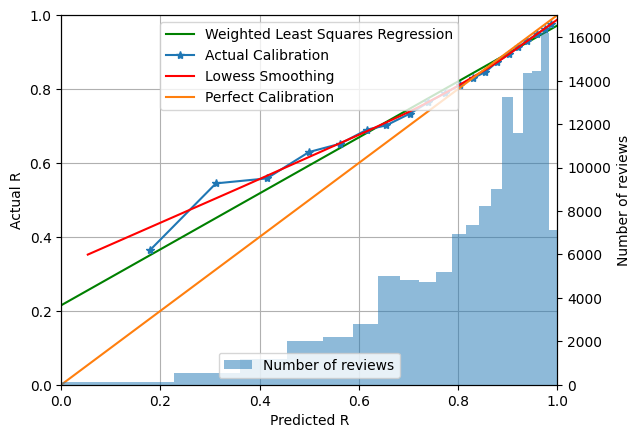

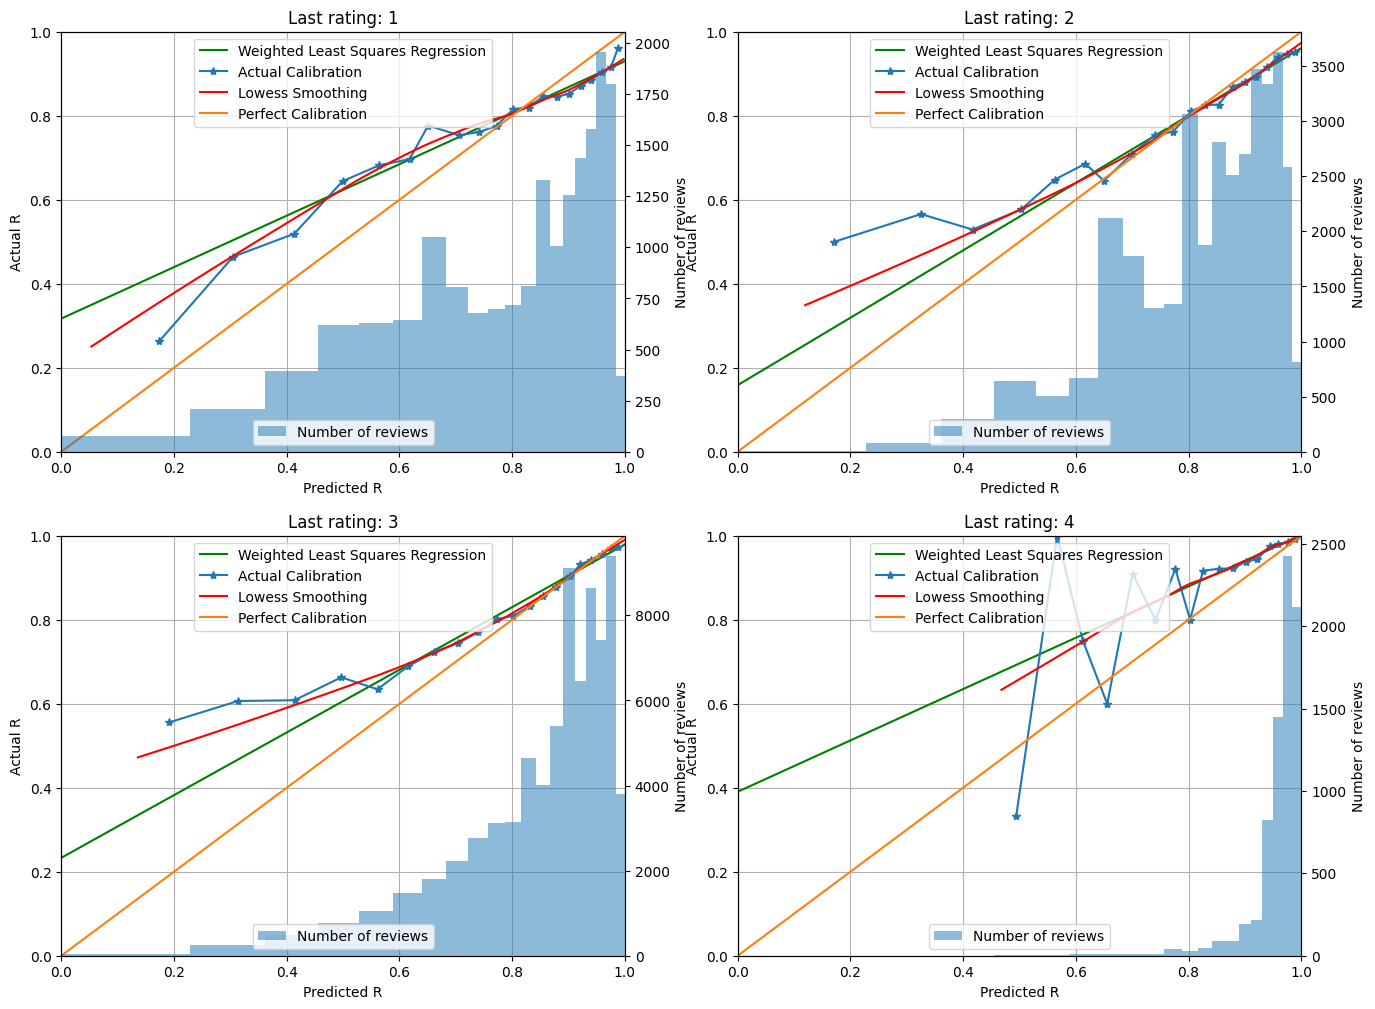

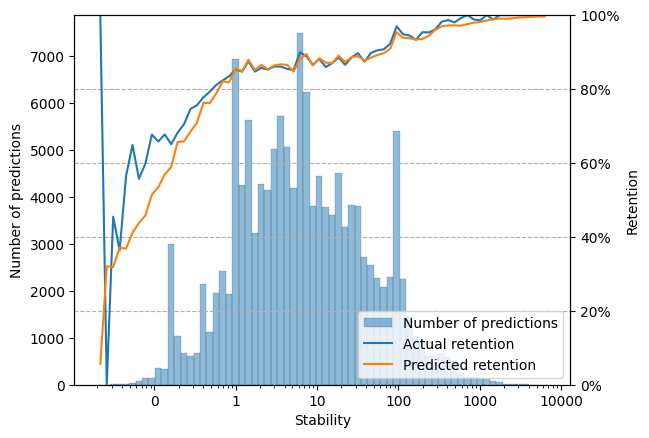

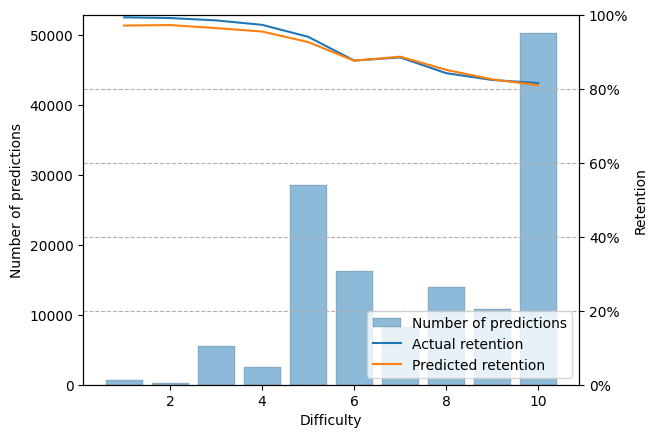

In [4]:
from fsrs_optimizer import Collection, power_forgetting_curve
from sklearn.metrics import log_loss

results = []

for w, dataset in zip(ws, datasets):
    my_collection = Collection(w)
    stabilities, difficulties = my_collection.batch_predict(dataset)
    dataset["stability"] = stabilities
    dataset["difficulty"] = difficulties
    dataset["p"] = power_forgetting_curve(dataset["delta_t"], dataset["stability"])
    results.append(dataset.copy())

dataset_join = pd.concat(results, ignore_index=True)
print(f"log loss: {log_loss(dataset_join['y'], dataset_join['p']):.4f}")
optimizer.calibration_graph(dataset_join)

  0%|          | 0/137144 [00:00<?, ?it/s]

log loss: 0.3660
RMSE(bins): 0.0361
R-squared: 0.7724
MAE: 0.0249
ICI: 0.0234
E50: 0.0147
E90: 0.0565
EMax: 0.3387
[0.27138506 0.69100518]

Last rating: 1
RMSE(bins): 0.0604
R-squared: 0.5042
MAE: 0.0530
ICI: 0.0524
E50: 0.0525
E90: 0.0887
EMax: 0.2088
[0.33126566 0.59250162]

Last rating: 2
RMSE(bins): 0.0434
R-squared: 0.7268
MAE: 0.0339
ICI: 0.0303
E50: 0.0267
E90: 0.0543
EMax: 0.3563
[0.24873306 0.69360984]

Last rating: 3
RMSE(bins): 0.0394
R-squared: 0.6973
MAE: 0.0238
ICI: 0.0208
E50: 0.0083
E90: 0.0566
EMax: 0.3408
[0.30327977 0.66682253]

Last rating: 4
RMSE(bins): 0.0355
R-squared: 0.1415
MAE: 0.0115
ICI: 0.0115
E50: 0.0042
E90: 0.0270
EMax: 0.1232
[0.41372788 0.5830042 ]


({'R-squared': 0.7724160387119221,
  'MAE': 0.02487161078704208,
  'ICI': 0.023423240044233507,
  'rmse': 0.03611261779128119},
 (<Figure size 640x480 with 2 Axes>,
  <Figure size 1600x1200 with 8 Axes>,
  <Figure size 640x480 with 2 Axes>,
  <Figure size 640x480 with 2 Axes>))

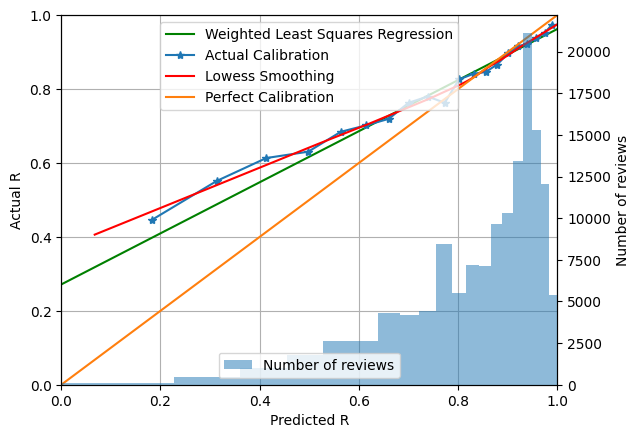

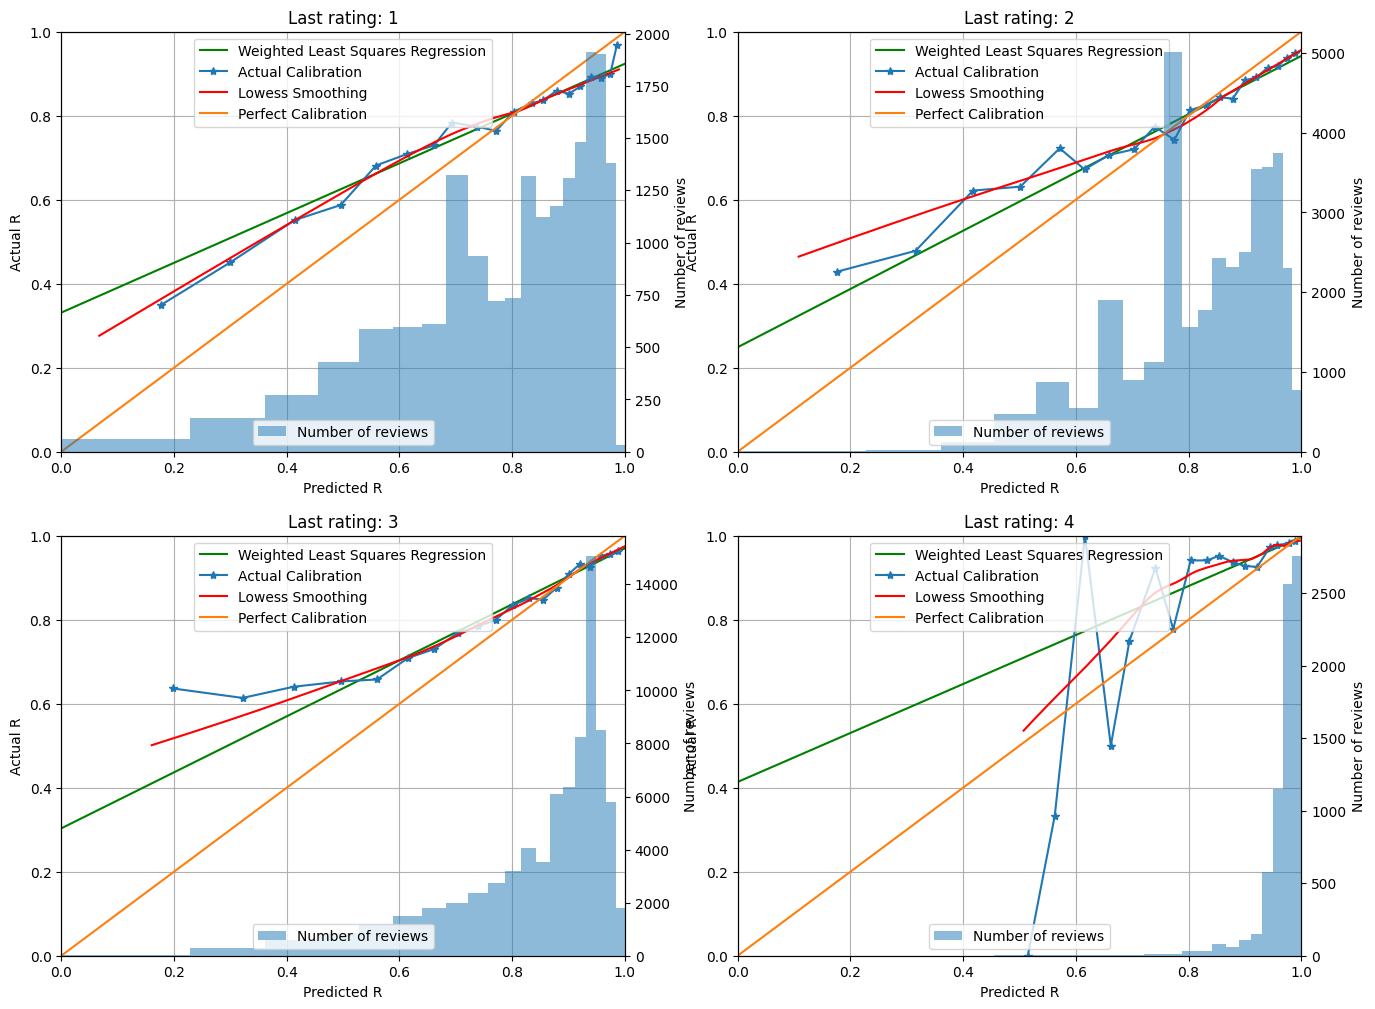

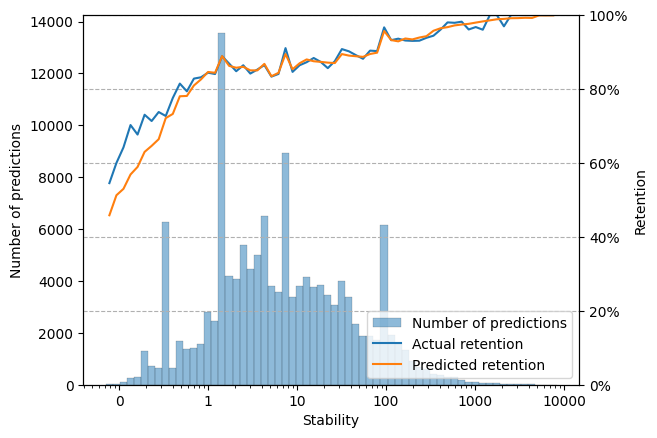

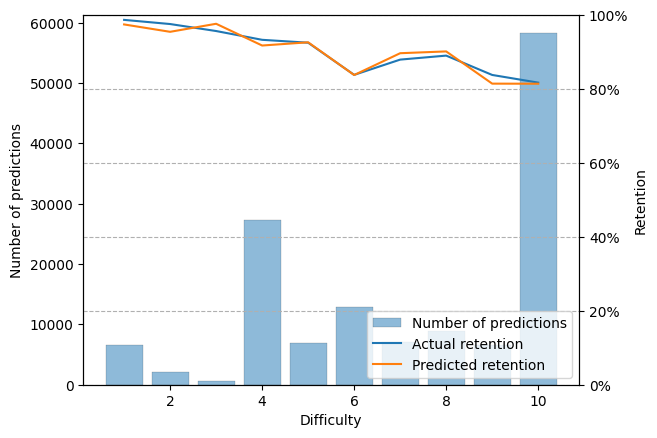

In [5]:
optimizer.define_model()
S0_dataset = dataset_join[dataset_join["i"] == 2].copy()
optimizer.S0_dataset_group = (
    S0_dataset.groupby(by=["r_history", "delta_t"], group_keys=False)
    .agg({"y": ["mean", "count"]})
    .reset_index()
)
optimizer.pretrain(dataset_join.copy(), verbose=False)
optimizer.train(verbose=False)
optimizer.evaluate()
print(f"log loss: {log_loss(optimizer.dataset['y'], optimizer.dataset['p']):.4f}")
optimizer.calibration_graph()

In [6]:
for w, (name, df) in zip(ws, dfs):
    print(name, len(df), w, sep="\n")
    print()

print("Global", optimizer.w, sep="\n")

Main::Japanese::WaniKani::Vocabulary
34407
[0.4461, 0.4461, 1.6285, 18.5739, 5.2576, 2.2505, 0.8738, 0.0037, 1.8975, 0.1927, 1.3165, 2.2966, 0.0109, 0.2249, 1.2372, 0.1546, 3.8597]

Main::Programming::Python::Syntax
1131
[0.2856, 0.4964, 1.1373, 13.8206, 5.1377, 1.4043, 0.9947, 0.0, 1.6538, 0.1555, 1.0521, 2.1124, 0.0869, 0.326, 1.4696, 0.2061, 3.0023]

Main::Japanese::WaniKani::Kanji
24238
[0.1636, 0.2192, 0.7637, 13.8206, 5.51, 2.2293, 0.7679, 0.1054, 1.639, 0.2893, 1.0584, 2.3938, 0.01, 0.1444, 1.7467, 0.1735, 3.9232]

Main::Science::Mechanisms
1402
[0.6396, 1.4003, 4.536, 4.536, 5.3109, 1.0562, 1.036, 0.0176, 1.5582, 0.2505, 0.9608, 2.078, 0.0902, 0.293, 1.6403, 0.1299, 2.6495]

Main::Science::Chemistry
6543
[0.6685, 0.786, 1.5817, 31.8875, 4.8031, 1.0372, 0.9372, 0.0, 1.7401, 0.0, 1.109, 2.0014, 0.1515, 0.2786, 1.3975, 0.2224, 3.3171]

Main::Geography::Россия
1333
[0.0367, 0.1072, 0.5365, 13.8206, 5.3347, 1.4123, 1.0456, 0.0, 1.4008, 0.2533, 0.7939, 2.007, 0.1633, 0.2355, 1.4912, 